# Notebook 03 — Recommendation to Purchase Funnel

Goal:
- Measure adoption rate after clinical recommendation
- Identify funnel drop-offs
- Compare adoption across markets, channels, and product tiers

In [29]:
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 4)

In [30]:
DATA_DIR = Path("../data/raw")

patients = pd.read_csv(DATA_DIR / "patients.csv")
recs = pd.read_csv(DATA_DIR / "recommendations.csv", parse_dates=["rec_date"])
tx = pd.read_csv(DATA_DIR / "transactions.csv", parse_dates=["tx_date"])

patients.shape, recs.shape, tx.shape

((50000, 6), (37358, 7), (70024, 8))

In [31]:
first_tx = (
    tx.sort_values(["patient_id", "tx_date"])
      .groupby("patient_id", as_index=False)
      .first()[["patient_id", "channel", "product_tier", "category", "tx_date"]]
      .rename(columns={
          "channel": "purchase_channel",
          "product_tier": "purchased_tier",
          "category": "purchased_category",
          "tx_date": "first_purchase_date"
      })
)

first_tx.head()

,patient_id,purchase_channel,purchased_tier,purchased_category,first_purchase_date
0,1,clinic,value,contacts,2024-10-29
1,2,retail,value,drops,2025-11-07
2,3,ecomm,mid,contacts,2024-08-13
3,5,retail,value,contacts,2025-09-10
4,12,clinic,value,contacts,2025-01-12


In [32]:
adoption = (
    recs.rename(columns={
        "product_tier": "recommended_tier",
        "category": "recommended_category"
    })
    .merge(first_tx, on="patient_id", how="left")
    .assign(adopted=lambda d: d["first_purchase_date"].notna())
    .merge(patients[["patient_id", "market_type"]], on="patient_id", how="left")
)

adoption.head()

,rec_id,patient_id,rec_date,recommended_category,recommended_tier,recommended_brand,expected_wear,purchase_channel,purchased_tier,purchased_category,first_purchase_date,adopted,market_type
0,1,1,2024-10-17,contacts,value,PureCare,daily,clinic,value,contacts,2024-10-29,True,emerging
1,2,2,2025-11-04,drops,value,BrightSight,NaN,retail,value,drops,2025-11-07,True,developed
2,3,3,2024-08-01,contacts,mid,PureCare,daily,ecomm,mid,contacts,2024-08-13,True,emerging
3,4,4,2024-05-13,contacts,value,VisionPro,daily,NaN,NaN,NaN,NaT,False,emerging
4,5,5,2025-08-28,contacts,value,OptiClear,daily,retail,value,contacts,2025-09-10,True,developed


In [33]:
adoption_rate = adoption["adopted"].mean()
adoption_rate

np.float64(0.6445741206702714)

In [34]:
WINDOW_DAYS = 30

adoption = adoption.assign(
    days_to_purchase=(adoption["first_purchase_date"] - adoption["rec_date"]).dt.days,
    adopted_30d=lambda d: d["days_to_purchase"].between(0, WINDOW_DAYS)
)

adoption["adopted_30d"].mean()

np.float64(0.6445741206702714)

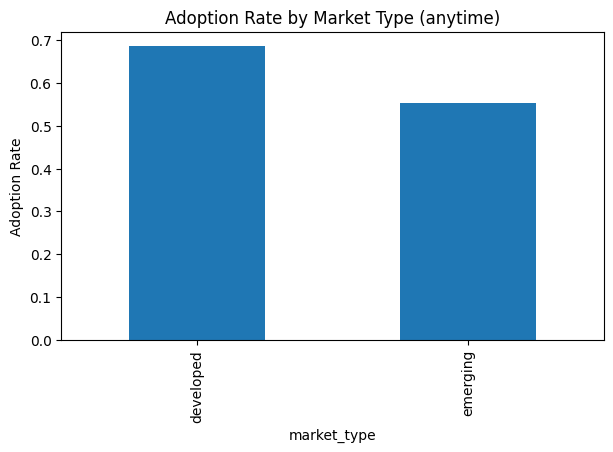

In [35]:
adoption_market = (
    adoption.groupby("market_type")["adopted"]
            .mean()
            .sort_values(ascending=False)
)

adoption_market.plot(kind="bar")
plt.title("Adoption Rate by Market Type (anytime)")
plt.ylabel("Adoption Rate")
plt.show()

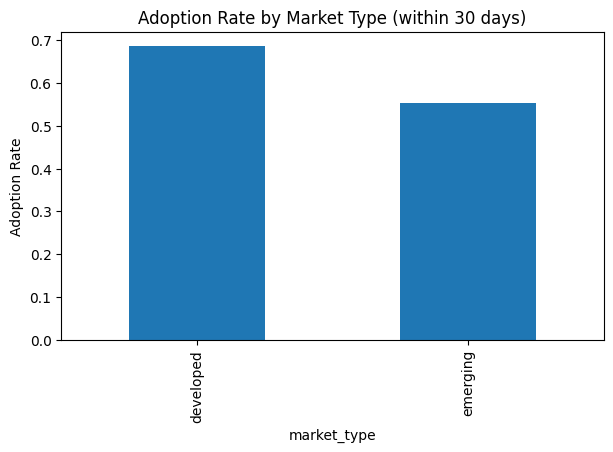

In [36]:
adoption_market_30d = (
    adoption.groupby("market_type")["adopted_30d"]
            .mean()
            .sort_values(ascending=False)
)

adoption_market_30d.plot(kind="bar")
plt.title(f"Adoption Rate by Market Type (within {WINDOW_DAYS} days)")
plt.ylabel("Adoption Rate")
plt.show()

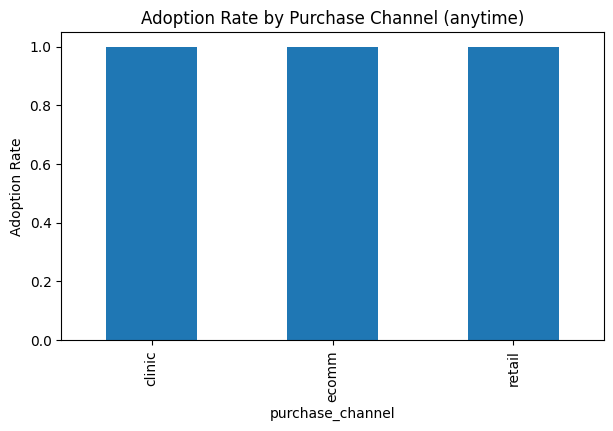

In [37]:
adoption_channel = (
    adoption.groupby("purchase_channel")["adopted"]
            .mean()
            .sort_values(ascending=False)
)

adoption_channel.plot(kind="bar")
plt.title("Adoption Rate by Purchase Channel (anytime)")
plt.ylabel("Adoption Rate")
plt.show()

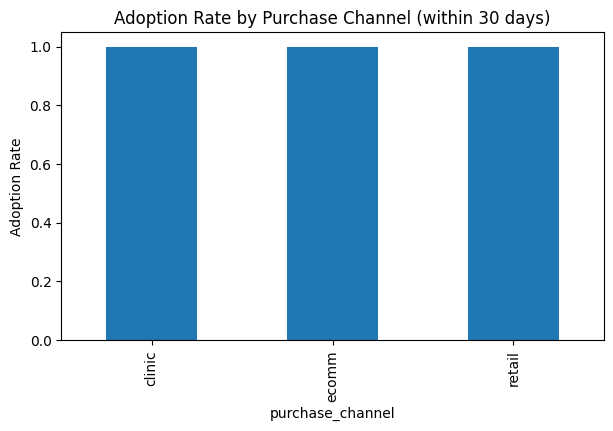

In [38]:
adoption_channel_30d = (
    adoption.groupby("purchase_channel")["adopted_30d"]
            .mean()
            .sort_values(ascending=False)
)

adoption_channel_30d.plot(kind="bar")
plt.title(f"Adoption Rate by Purchase Channel (within {WINDOW_DAYS} days)")
plt.ylabel("Adoption Rate")
plt.show()

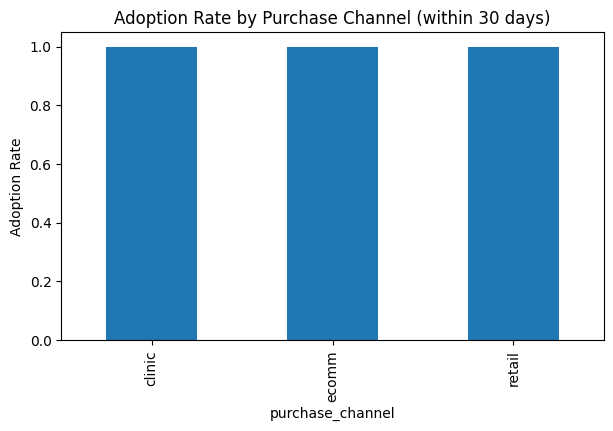

In [39]:
adoption_channel_30d = (
    adoption.groupby("purchase_channel")["adopted_30d"]
            .mean()
            .sort_values(ascending=False)
)

adoption_channel_30d.plot(kind="bar")
plt.title(f"Adoption Rate by Purchase Channel (within {WINDOW_DAYS} days)")
plt.ylabel("Adoption Rate")
plt.show()

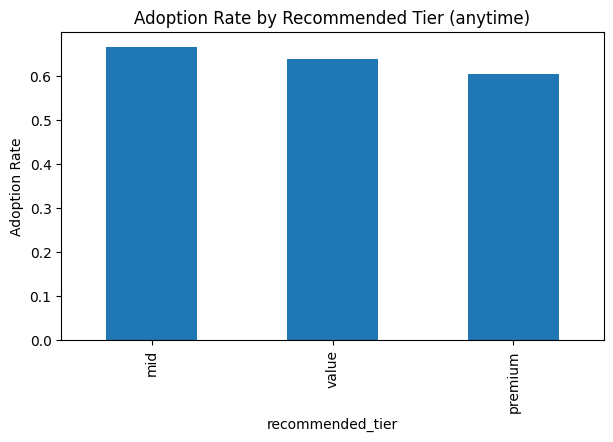

In [40]:
adoption_tier = (
    adoption.groupby("recommended_tier")["adopted"]
            .mean()
            .sort_values(ascending=False)
)

adoption_tier.plot(kind="bar")
plt.title("Adoption Rate by Recommended Tier (anytime)")
plt.ylabel("Adoption Rate")
plt.show()

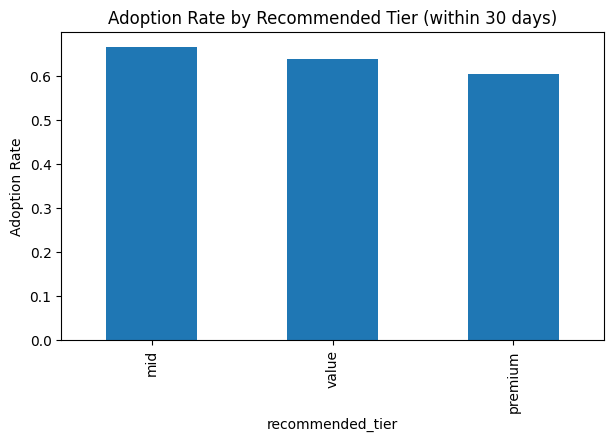

In [41]:
adoption_tier_30d = (
    adoption.groupby("recommended_tier")["adopted_30d"]
            .mean()
            .sort_values(ascending=False)
)

adoption_tier_30d.plot(kind="bar")
plt.title(f"Adoption Rate by Recommended Tier (within {WINDOW_DAYS} days)")
plt.ylabel("Adoption Rate")
plt.show()

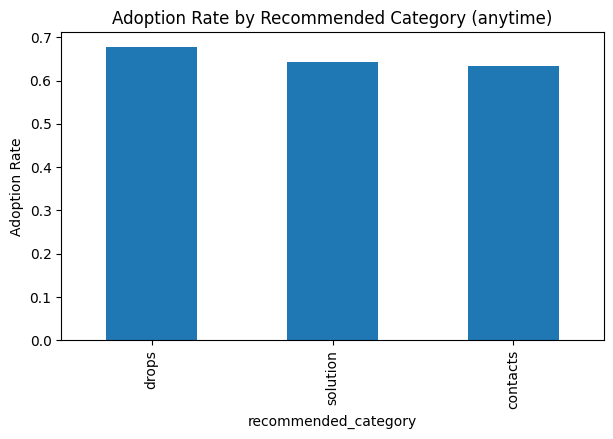

In [42]:
adoption_cat = (
    adoption.groupby("recommended_category")["adopted"]
            .mean()
            .sort_values(ascending=False)
)

adoption_cat.plot(kind="bar")
plt.title("Adoption Rate by Recommended Category (anytime)")
plt.ylabel("Adoption Rate")
plt.show()

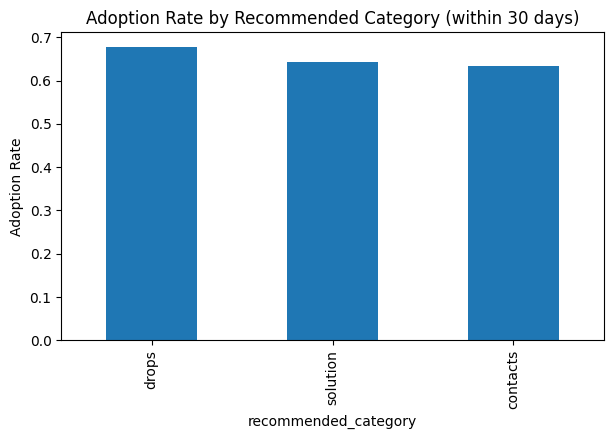

In [43]:
adoption_cat_30d = (
    adoption.groupby("recommended_category")["adopted_30d"]
            .mean()
            .sort_values(ascending=False)
)

adoption_cat_30d.plot(kind="bar")
plt.title(f"Adoption Rate by Recommended Category (within {WINDOW_DAYS} days)")
plt.ylabel("Adoption Rate")
plt.show()

In [44]:
kpi = pd.DataFrame({
    "metric": [
        "Total recommendations (rows)",
        "Unique recommended patients",
        "Overall adoption rate (anytime)",
        f"Adoption rate (within {WINDOW_DAYS} days)",
    ],
    "value": [
        len(adoption),
        adoption["patient_id"].nunique(),
        adoption["adopted"].mean(),
        adoption["adopted_30d"].mean(),
    ]
})

kpi

,metric,value
0,Total recommendations (rows),37358.000000
1,Unique recommended patients,37358.000000
2,Overall adoption rate (anytime),0.644574
3,Adoption rate (within 30 days),0.644574


In [45]:
segment = (
    adoption.groupby(["market_type", "recommended_tier", "purchase_channel"])
           .agg(
               recommended_patients=("patient_id", "nunique"),
               adoption_rate=("adopted", "mean"),
               adoption_30d=("adopted_30d", "mean"),
           )
           .reset_index()
           .sort_values(["recommended_patients"], ascending=False)
)

segment.head(15)

,market_type,recommended_tier,purchase_channel,recommended_patients,adoption_rate,adoption_30d
2,developed,mid,retail,4167,1.0,1.0
1,developed,mid,ecomm,4096,1.0,1.0
7,developed,value,ecomm,1977,1.0,1.0
4,developed,premium,ecomm,1952,1.0,1.0
5,developed,premium,retail,1903,1.0,1.0
8,developed,value,retail,1863,1.0,1.0
11,emerging,mid,retail,1639,1.0,1.0
17,emerging,value,retail,1513,1.0,1.0
0,developed,mid,clinic,902,1.0,1.0
10,emerging,mid,ecomm,902,1.0,1.0


## Key Funnel Insights (Draft)

- Adoption is not guaranteed after recommendation, confirming a meaningful funnel drop-off.
- Adoption differs by market type (developed vs emerging), which may reflect access and affordability constraints.
- Purchase channel strongly influences conversion efficiency, suggesting that distribution strategy matters.
- Recommended tier/category impacts adoption — useful for aligning product strategy with patient segments.
- Next step: retention and cohorts (do adopters stay active and repurchase?).